In [1]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import networkx as nx

In [2]:
stations = ['A', 'B', 'C', 'D', 'E', 'S1', 'S2']
transitions = {
    'S1': ['A', 'B', 'C'],
    'S2': ['A', 'B', 'C', 'D', 'E']
}

In [3]:
G = nx.Graph()

for key, value in transitions.items():
    for val in value:
        G.add_edge(key, val)

{'S1': Text(-0.7017608099990026, -0.49296992287187025, 'S1'),
 'A': Text(-0.6182501822804963, 0.19171727194767452, 'A'),
 'B': Text(-0.03421880820305773, -0.6497085118622301, 'B'),
 'C': Text(-0.2921951431132157, -0.21171547185568487, 'C'),
 'S2': Text(0.19872308768631777, 0.13638949150490362, 'S2'),
 'D': Text(0.9999999999999999, 0.12858750924647702, 'D'),
 'E': Text(0.447701855909455, 0.8976996338907296, 'E')}

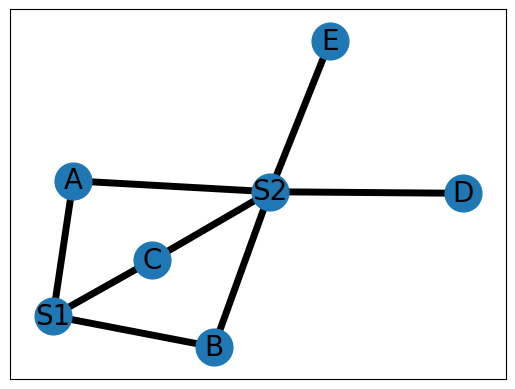

In [4]:
pos = nx.spring_layout(G, seed=1)
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, width=5)
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

In [5]:
vagon_type = ['A', 'B', 'C']
lacomotive_type = ['S1', 'S2']

start_situation_state = {
    'A': [
        vagon_type[0],
        vagon_type[1],
        vagon_type[0],
        vagon_type[1],
        vagon_type[1],
        vagon_type[0],
    ],
    'B': [
        vagon_type[1],
        vagon_type[2],
        vagon_type[1],
    ],
    'C': [
        vagon_type[0],
        vagon_type[1],
        vagon_type[1],
    ],
    'D': [
        vagon_type[0],
        vagon_type[1],
    ],
    'E': [
        vagon_type[1],
        vagon_type[0],
        vagon_type[0],
    ],
    'S1': [
        lacomotive_type[0],
    ],
    'S2': [
        lacomotive_type[1],
    ],
}

In [6]:
# 0 - простой
# 1 - перевести на другую ветку
# 2 - присоединить вагон
# 3 - отсоединить вагон

operations_cost = [100, 10, 2, 2]

In [7]:
VAGON_COUNT = 17
MAX_OPERATIONS = 20
LENGTH_CHROM = VAGON_COUNT * MAX_OPERATIONS     # длина хромосомы, подлежащей оптимизации
 
# константы генетического алгоритма
POPULATION_SIZE = 500   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.1        # вероятность мутации индивидуума
MAX_GENERATIONS = 30    # максимальное количество поколений

In [8]:
RANDOM_SEED = 0
random.seed(RANDOM_SEED)

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [10]:
def create_random_list(max_range, count):
    operations_count = random.randint(1, count)
    r = []
    for _ in range(count):
        if operations_count > 0:
            new_oper = random.randint(0, max_range)
            if new_oper == 1:
                state = random.choice(['A', 'B', 'C', 'D', 'E', 'S1', 'S2'])
                r.append({f'{new_oper}': state})
            else:
                r.append({f'{new_oper}': None})
        else:
            r.append({'0': None})
        operations_count -= 1
    return r

In [11]:
create_random_list(4, 20)

[{'3': None},
 {'0': None},
 {'2': None},
 {'4': None},
 {'3': None},
 {'3': None},
 {'2': None},
 {'3': None},
 {'2': None},
 {'4': None},
 {'1': 'E'},
 {'1': 'C'},
 {'1': 'S2'},
 {'0': None},
 {'0': None},
 {'0': None},
 {'0': None},
 {'0': None},
 {'0': None},
 {'0': None}]

In [23]:
toolbox = base.Toolbox()
toolbox.register("randomOper", create_random_list, len(operations_cost) - 1, MAX_OPERATIONS)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.randomOper, VAGON_COUNT)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [65]:
population = toolbox.populationCreator(n=POPULATION_SIZE)

In [64]:
def shedule_cost(individual):
    current_cost = 0
    for vagons in individual:
        for curr_vagon in vagons:
            is_in_lacomotive = 0
            for key, val in curr_vagon.items():
                if val in ['S1', 'S2']:
                    is_in_lacomotive += 1
                if is_in_lacomotive >= 2:
                    current_cost += 0
                else:
                    current_cost += operations_cost[int(key)]
    return current_cost,

In [15]:
def mate(ind1, ind2):
    ind1[:(VAGON_COUNT//2)], ind2[:(VAGON_COUNT//2)] = ind2[:(VAGON_COUNT//2)], ind1[:(VAGON_COUNT//2)]
    return ind1, ind2

In [16]:
def mut(individual, indpb):
    for ind in individual:
        tools.mutShuffleIndexes(ind, indpb)
 
    return individual,

In [66]:
toolbox.register("evaluate", shedule_cost)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", mate)
toolbox.register("mutate", mut, indpb=1.0/LENGTH_CHROM/10)

In [36]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [67]:
population, logbook = algorithms.eaSimple(population, toolbox,
                                        cxpb=P_CROSSOVER/VAGON_COUNT,
                                        mutpb=P_MUTATION/VAGON_COUNT,
                                        ngen=MAX_GENERATIONS,
                                        stats=stats,
                                        verbose=True)

gen	nevals	min  	avg    
0  	500   	15722	21279.7
1  	19    	15722	19986.7
2  	29    	15722	19015.1
3  	19    	15722	18133.6
4  	22    	14910	17473.2
5  	39    	14666	16741.7
6  	22    	14666	16048  
7  	28    	14666	15591.7
8  	34    	14666	15339.5
9  	40    	14666	15006.5
10 	31    	14666	14772.1
11 	21    	14666	14684.7
12 	40    	14666	14666.4
13 	25    	14666	14666  
14 	48    	14666	14666  
15 	31    	14666	14666  
16 	38    	14666	14666  
17 	39    	14666	14666  
18 	41    	14666	14666  
19 	23    	14666	14666  
20 	28    	14666	14666  
21 	32    	14666	14666  
22 	35    	14666	14666  
23 	29    	14666	14666  
24 	24    	14666	14666  
25 	33    	14666	14666  
26 	27    	14666	14666  
27 	47    	14666	14666  
28 	26    	14666	14666  
29 	37    	14666	14666  
30 	16    	14666	14666  


In [68]:
maxFitnessValues, meanFitnessValues = logbook.select("min", "avg")

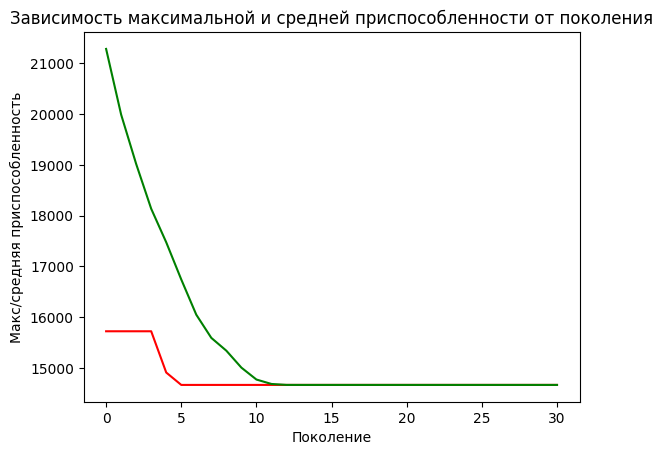

In [69]:
import matplotlib.pyplot as plt

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
 
plt.show()

In [75]:
for vagon in population[0]:
    print(vagon)

[{'1': 'B'}, {'1': 'A'}, {'0': None}, {'3': None}, {'2': None}, {'3': None}, {'0': None}, {'3': None}, {'1': 'D'}, {'1': 'A'}, {'1': 'C'}, {'0': None}, {'2': None}, {'3': None}, {'2': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}]
[{'2': None}, {'1': 'E'}, {'3': None}, {'1': 'S2'}, {'0': None}, {'0': None}, {'1': 'A'}, {'1': 'S1'}, {'2': None}, {'2': None}, {'2': None}, {'3': None}, {'3': None}, {'3': None}, {'2': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}]
[{'0': None}, {'3': None}, {'3': None}, {'2': None}, {'0': None}, {'3': None}, {'3': None}, {'2': None}, {'0': None}, {'1': 'D'}, {'0': None}, {'3': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}]
[{'1': 'D'}, {'2': None}, {'1': 'C'}, {'3': None}, {'3': None}, {'1': 'E'}, {'2': None}, {'3': None}, {'0': None}, {'1': 'B'}, {'1': 'C'}, {'1': 'C'}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': Non